# **Cross-wavelet coherence analysis**

### **Import libraries & load data**

In [421]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sys import path
from __future__ import division
from matplotlib import pyplot
from scipy.interpolate import interp1d
import pycwt as wavelet
from pycwt.helpers import find
import flirt
from scipy.stats import mannwhitneyu, kruskal
import os
from transformers import pipeline
import torch
import librosa
import soundfile as sf
import torchaudio
import pickle

In [422]:
data_dir = '../data/preprocessed/'
mindware_dir = '../data/mindware_processed/'

In [423]:
sessions = ['NN', 'NY', 'MG', 'VM']
conditions_full = ['positive', 'negative', 'neutral']
conditions_NY_ecg = ['positive', 'negative']
conditions_VM_MG = ['research']

person_2 = 'YW'

ecg_p1 = {}
ecg_p2 = {}
mw_p1 = {}
mw_p2 = {}

for session in sessions:
    person_1 = session
    ecg_p1[session] = {}
    ecg_p2[session] = {}
    mw_p1[session] = {}
    mw_p2[session] = {}
    if session == 'NN' or session == 'NY':
        if session == 'NN':
            conditions = conditions_full
        else:
            conditions = conditions_NY_ecg
        for condition in conditions:
            df_ecg_p1 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_1}_{condition}.csv')
            df_ecg_p2 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_2}_{condition}.csv')
            df_mw_p1 = pd.read_csv(f'{mindware_dir}{session}_mindware_IBI_{person_1}_{condition}.csv')
            df_mw_p2 = pd.read_csv(f'{mindware_dir}{session}_mindware_IBI_{person_2}_{condition}.csv')
            df_ecg_p1['timestamp'] = pd.to_datetime(df_ecg_p1['timestamp'])
            df_ecg_p2['timestamp'] = pd.to_datetime(df_ecg_p2['timestamp'])
            df_mw_p1['timestamp'] = pd.to_datetime(df_mw_p1['timestamp'])
            df_mw_p2['timestamp'] = pd.to_datetime(df_mw_p2['timestamp'])
            ecg_p1[session][condition] = df_ecg_p1
            ecg_p2[session][condition] = df_ecg_p2
            mw_p1[session][condition] = df_mw_p1
            mw_p2[session][condition] = df_mw_p2
    else:
        condition = conditions_VM_MG[0]
        df_ecg_p1 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_1}.csv')
        df_ecg_p2 = pd.read_csv(f'{data_dir}{session}_preprocessed_{person_2}.csv')
        df_mw_p1 = pd.read_csv(f'{mindware_dir}{session}_mindware_IBI_{person_1}.csv')
        df_mw_p2 = pd.read_csv(f'{mindware_dir}{session}_mindware_IBI_{person_2}.csv')
        df_ecg_p1['timestamp'] = pd.to_datetime(df_ecg_p1['timestamp'])
        df_ecg_p2['timestamp'] = pd.to_datetime(df_ecg_p2['timestamp'])
        df_mw_p1['timestamp'] = pd.to_datetime(df_mw_p1['timestamp'])
        df_mw_p2['timestamp'] = pd.to_datetime(df_mw_p2['timestamp'])
        ecg_p1[session][condition] = df_ecg_p1
        ecg_p2[session][condition] = df_ecg_p2
        mw_p1[session][condition] = df_mw_p1
        mw_p2[session][condition] = df_mw_p2

## **IBI analysis**

### **Basic visualization**

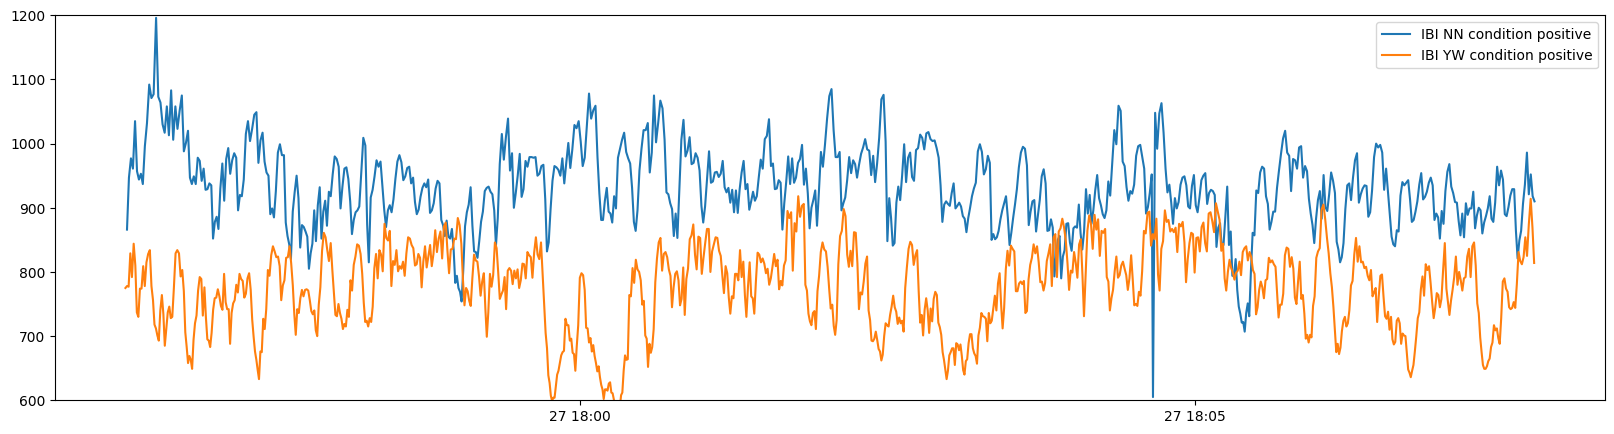

In [424]:
session = 'NN'
condition = 'positive'
person_1 = session
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(mw_p1[session][condition]['timestamp'], mw_p1[session][condition]['IBI'], label=f'IBI {person_1} condition {condition}')
ax.plot(mw_p2[session][condition]['timestamp'], mw_p2[session][condition]['IBI'], label=f'IBI {person_2} condition {condition}')
ax.set_ylim(600, 1200)
ax.legend()
plt.show()

### **Wavelet basics**

#### **Continuous vs discrete wavelet transform**

Continuous wavelet transform compares a signal with shifted and scaled (contracted or streched) copies of a basic wavelet. If $\psi(t)$ is a wavelet centered at $t=0$ with time support on $[-T/2, T/2]$, then $\frac{1}{s}\psi(\frac{t-u}{s})$ is centered at $t=u$ with time support $[-\frac{sT}{2}+u, \frac{sT}{2}+u]$. $s$ is a scaling factor; when $s>1$, the wavelet is streched (slow changes), and when $0<s<1$, the wavelet is contracted (fast changes). 

The major difference between continuous wavelet transform and discrete wavelet transform is that how the scale parameter ($s$) is discretized. continuous wavelet transform discretizes scale more finely than the discrete wavelet transform.

> Reference: https://www.mathworks.com/help/wavelet/gs/continuous-and-discrete-wavelet-transforms.html

In [425]:
ibi_array_p1 = {}
ibi_array_p2 = {}
time_array_p1 = {}
time_array_p2 = {}

for session in sessions:
    ibi_array_p1[session] = {}
    ibi_array_p2[session] = {}
    time_array_p1[session] = {}
    time_array_p2[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        ibi_array_p1[session][condition] = mw_p1[session][condition]['IBI'].values
        ibi_array_p2[session][condition] = mw_p2[session][condition]['IBI'].values
        time_array_p1[session][condition] = mw_p1[session][condition]['time'].values
        time_array_p2[session][condition] = mw_p2[session][condition]['time'].values

### Re-sampling

Because the wavelet analyis requires arrays with a fixed sampling rate, re-sampling the IBI arrays.

In [426]:
new_t = {}
resampled_ibi_p1 = {}
resampled_ibi_p2 = {}

for session in sessions:
    new_t[session] = {}
    resampled_ibi_p1[session] = {}
    resampled_ibi_p2[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        # Re-samplg at 1 Hz
        new_t[session][condition] = np.arange(max(time_array_p1[session][condition][0], time_array_p2[session][condition][0]), min(time_array_p1[session][condition][-1], time_array_p2[session][condition][-1]), 1000)
        interp_func_p1 = interp1d(time_array_p1[session][condition], ibi_array_p1[session][condition], kind='quadratic')
        resampled_ibi_p1[session][condition] = interp_func_p1(new_t[session][condition])
        interp_func_p2 = interp1d(time_array_p2[session][condition], ibi_array_p2[session][condition], kind='quadratic')
        resampled_ibi_p2[session][condition] = interp_func_p2(new_t[session][condition])

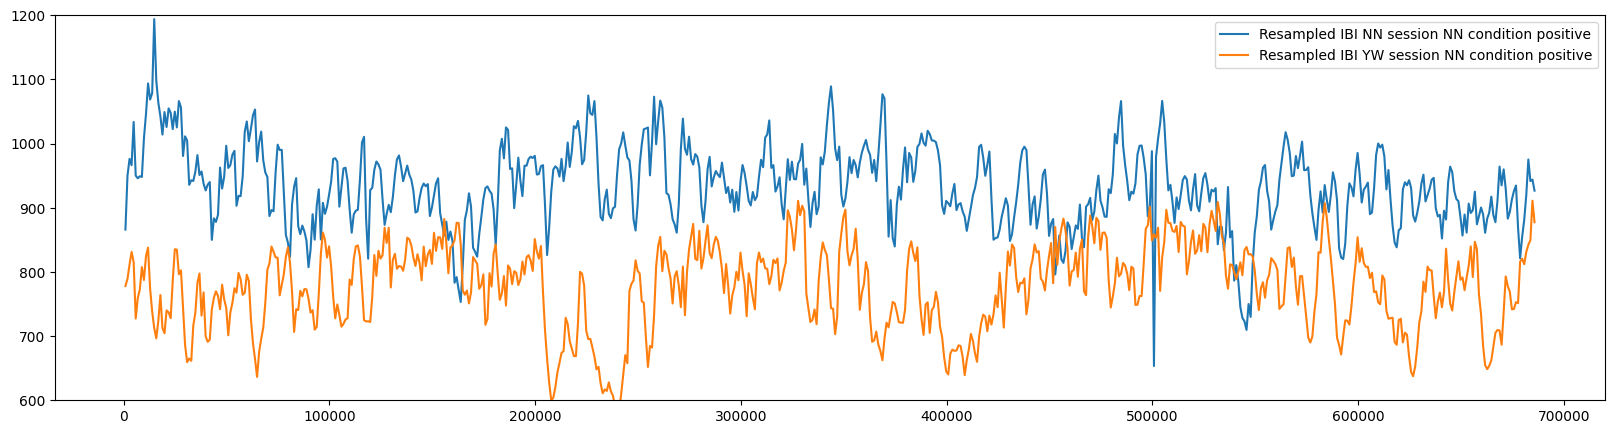

In [427]:
session = 'NN'
condition = 'positive'
person_1 = session
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(new_t[session][condition], resampled_ibi_p1[session][condition], label=f'Resampled IBI {person_1} session {session} condition {condition}')
ax.plot(new_t[session][condition], resampled_ibi_p2[session][condition], label=f'Resampled IBI {person_2} session {session} condition {condition}')
ax.set_ylim(600, 1200)
ax.legend()
plt.show()

### Standardization

Before applying the wavelet analysis, subtract a mean value and normalize by standard deviation.

In [428]:
ibi_standardized_p1 = {}
ibi_standardized_p2 = {}

for session in sessions:
    ibi_standardized_p1[session] = {}
    ibi_standardized_p2[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        ibi_standardized_p1[session][condition] = (resampled_ibi_p1[session][condition] - np.mean(resampled_ibi_p1[session][condition])) / np.std(resampled_ibi_p1[session][condition])
        ibi_standardized_p2[session][condition] = (resampled_ibi_p2[session][condition] - np.mean(resampled_ibi_p2[session][condition])) / np.std(resampled_ibi_p2[session][condition])

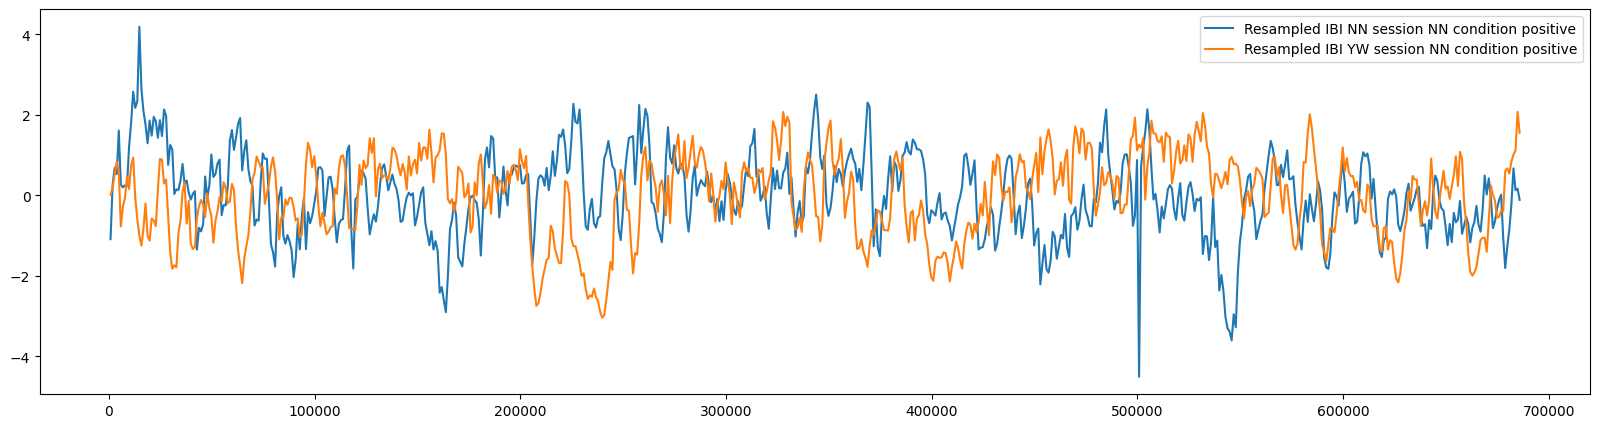

In [429]:
session = 'NN'
condition = 'positive'
person_1 = session
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(new_t[session][condition], ibi_standardized_p1[session][condition], label=f'Resampled IBI {person_1} session {session} condition {condition}')
ax.plot(new_t[session][condition], ibi_standardized_p2[session][condition], label=f'Resampled IBI {person_2} session {session} condition {condition}')
ax.legend()
plt.show()

### Decide parameters for wavelet analysis

#### Choose a type of Wavelet
**Morlet wavelet**: Has high frequency resolution

**Paul wavelet**:

**Derivative of a Gaussian wavelet family**:

**Mexican hat wavelet**:


> Refefence:Torrence, C., & Compo, G. P. (1998). A practical guide to wavelet analysis. Bulletin of the American Meteorological Society, 79(1), 61–78.

In [430]:
fs = 1
dt = 1/fs
mother = wavelet.Morlet(6)
s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 seconds = 0.5 seconds
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves

### Continuous wavelet transform

`cwt(signal, dt, dj=1 / 12, s0=-1, J=-1, wavelet='morlet', freqs=None)`

This function implements continuous wavelet transform.

**Parameters**

- `signal`: Signal to implement wavelet transform.
- `dt`: Sampling interval of the signal.
- `dj`: Spacing between discrete value. Smaller value results in higher resolution but slower calculation.
- `s0`: Smallest scale of the wavelet. By default, 2 * dt.
- `J`: Number of scales. Scales range from s0 up to s0 * 2*(J * dj), which gives a total of (J + 1) scales. 
- `wavelet`: Instance of wavelet class or string mother wavelet class.
- `freqs`: Custom frequencies to use instead of the scales provided.

**Returns**
- `W`: Wavelet transform results. Has (J+1) * N dimensions.
- `freqs`: Vector of Fourier frequencies (in 1 / time units) that corresponds to the wavelet scales.
- `coi`: Returns the cone of influence, which is a vector of N points containing the maximum Fourier period of useful information at that particular time.
- `fft`: Normalized fast Fourier transform of the input signal. 
- `fftfreq`: Fourier frequencies (in 1/time units) for the calculated FFT spectrum.

#### Double-check if wavelet coherence between two same signals will be 1

In [431]:
session = 'MG'
condition = 'research'
N = len(new_t[session][condition])
wct_auto, awct_auto, coi_auto, freq_auto, sig_auto = wavelet.wct(ibi_standardized_p1[session][condition], ibi_standardized_p1[session][condition], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=False)

NOTE: WCT significance loaded from cache.



/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/pycwt/wavelet.py:633: RuntimeWarning: invalid value encountered in arctanh
  aa = numpy.round(numpy.arctanh(numpy.array([al1, al2]) * 4))


In [432]:
print("Max:", np.max(wct_auto))
print("Min:", np.min(wct_auto))
print("Mean:", np.mean(wct_auto))

Max: 1.000000000000009
Min: 0.9999999999999889
Mean: 1.0


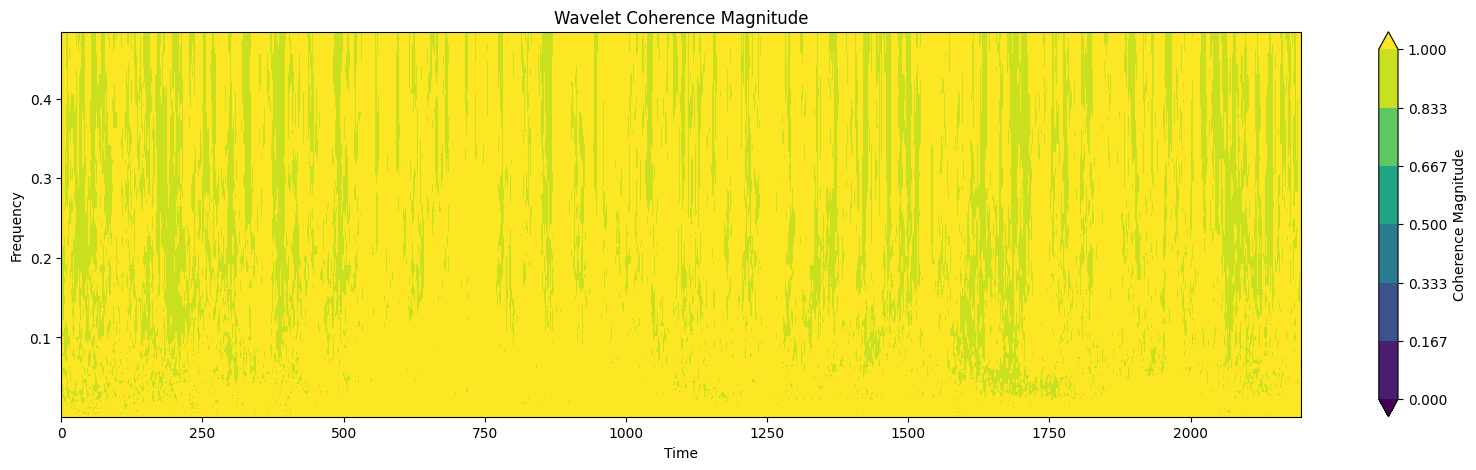

In [433]:
plt.figure(figsize=(20, 5))
plt.contourf(np.arange(len(ibi_standardized_p1[session][condition])) * dt, freq_auto, wct_auto, levels=np.linspace(0, 1, 7), extend='both')
plt.title('Wavelet Coherence Magnitude')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Coherence Magnitude')
plt.show()

### Use surrogate data to determine threshold

In [434]:
import itertools
data_list = [
    {"session": "NN", "condition": "positive", "person": "NN"},
    {"session": "NN", "condition": "positive", "person": "YW"},
    {"session": "NN", "condition": "negative", "person": "NN"},
    {"session": "NN", "condition": "negative", "person": "YW"},
    {"session": "NN", "condition": "neutral", "person": "NN"},
    {"session": "NN", "condition": "neutral", "person": "YW"},
    {"session": "NY", "condition": "positive", "person": "NY"},
    {"session": "NY", "condition": "positive", "person": "YW"},
    {"session": "NY", "condition": "negative", "person": "NY"},
    {"session": "NY", "condition": "negative", "person": "YW"},
    {"session": "MG", "condition": "research", "person": "MG"},
    {"session": "MG", "condition": "research", "person": "YW"},
    {"session": "VM", "condition": "research", "person": "VM"},
    {"session": "VM", "condition": "research", "person": "YW"},
]

data_df = pd.DataFrame(data_list)

# 2. Create all possible pairs
pairs = list(itertools.product(data_df.index, data_df.index))

# 3. Filter out pairs that are not valid
filtered_pairs = set()
for i, j in pairs:
    row_i = data_df.iloc[i]
    row_j = data_df.iloc[j]
    
    # Remove pairs with the same person
    if row_i['person'] == row_j['person']:
        continue
    
    # Remove pairs with the same session and condition
    if row_i['session'] == row_j['session'] and row_i['condition'] == row_j['condition']:
        continue
    
    pair = tuple(sorted([i, j]))
    filtered_pairs.add(pair)

surrogate_pairs = pd.DataFrame([
    {
        "index1": pair[0], 
        "index2": pair[1], 
        "session1": data_df.iloc[pair[0]]['session'], 
        "condition1": data_df.iloc[pair[0]]['condition'], 
        "person1": data_df.iloc[pair[0]]['person'], 
        "session2": data_df.iloc[pair[1]]['session'], 
        "condition2": data_df.iloc[pair[1]]['condition'], 
        "person2": data_df.iloc[pair[1]]['person']
    }
    for pair in filtered_pairs
])

surrogate_pairs

,index1,index2,session1,condition1,person1,session2,condition2,person2
0,6,12,NY,positive,NY,VM,research,VM
1,3,4,NN,negative,YW,NN,neutral,NN
2,4,9,NN,neutral,NN,NY,negative,YW
3,4,6,NN,neutral,NN,NY,positive,NY
4,4,12,NN,neutral,NN,VM,research,VM
5,3,10,NN,negative,YW,MG,research,MG
6,5,10,NN,neutral,YW,MG,research,MG
7,0,5,NN,positive,NN,NN,neutral,YW
8,8,12,NY,negative,NY,VM,research,VM
9,1,6,NN,positive,YW,NY,positive,NY


In [435]:
ibi_standardized_all = {}

for session in ibi_standardized_p1.keys():
    person = session
    ibi_standardized_all[session] = {}
    for condition in ibi_standardized_p1[session].keys():
        ibi_standardized_all[session][condition] = {}
        ibi_standardized_all[session][condition][person] = ibi_standardized_p1[session][condition]
for session in ibi_standardized_p2.keys():
    person = 'YW'
    for condition in ibi_standardized_p2[session].keys():
        ibi_standardized_all[session][condition][person] = ibi_standardized_p2[session][condition]

In [436]:
wct_surrogate = []

for pair_i in range(len(surrogate_pairs)):
    print(f'Processing pair {pair_i+1}/{len(surrogate_pairs)}')
    session1 = surrogate_pairs.loc[pair_i, 'session1']
    condition1 = surrogate_pairs.loc[pair_i, 'condition1']
    person1 = surrogate_pairs.loc[pair_i, 'person1']
    session2 = surrogate_pairs.loc[pair_i, 'session2']
    condition2 = surrogate_pairs.loc[pair_i, 'condition2']
    person2 = surrogate_pairs.loc[pair_i, 'person2']
    print(f'    {session1} {condition1} {person1} vs {session2} {condition2} {person2}')

    max_idx = min(len(ibi_standardized_all[session1][condition1][person1]), len(ibi_standardized_all[session2][condition2][person2]))
    wct, awct, coi, freq, sig = wavelet.wct(ibi_standardized_all[session1][condition1][person1][:max_idx], ibi_standardized_all[session2][condition2][person2][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
    wct_surrogate.append(wct)

Processing pair 1/59
    NY positive NY vs VM research VM
NOTE: WCT significance loaded from cache.

Processing pair 2/59
    NN negative YW vs NN neutral NN
NOTE: WCT significance loaded from cache.

Processing pair 3/59
    NN neutral NN vs NY negative YW
NOTE: WCT significance loaded from cache.

Processing pair 4/59
    NN neutral NN vs NY positive NY
NOTE: WCT significance loaded from cache.

Processing pair 5/59
    NN neutral NN vs VM research VM


/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/pycwt/wavelet.py:633: RuntimeWarning: invalid value encountered in arctanh
  aa = numpy.round(numpy.arctanh(numpy.array([al1, al2]) * 4))


NOTE: WCT significance loaded from cache.

Processing pair 6/59
    NN negative YW vs MG research MG
NOTE: WCT significance loaded from cache.

Processing pair 7/59
    NN neutral YW vs MG research MG
NOTE: WCT significance loaded from cache.

Processing pair 8/59
    NN positive NN vs NN neutral YW
NOTE: WCT significance loaded from cache.

Processing pair 9/59
    NY negative NY vs VM research VM
NOTE: WCT significance loaded from cache.

Processing pair 10/59
    NN positive YW vs NY positive NY
NOTE: WCT significance loaded from cache.

Processing pair 11/59
    NN positive NN vs NY negative NY
NOTE: WCT significance loaded from cache.

Processing pair 12/59
    NN negative NN vs NN neutral YW
NOTE: WCT significance loaded from cache.

Processing pair 13/59
    NN negative NN vs MG research YW
NOTE: WCT significance loaded from cache.

Processing pair 14/59
    MG research MG vs VM research VM
NOTE: WCT significance loaded from cache.

Processing pair 15/59
    NN positive NN vs MG

95th percentile: 0.7984759313134534


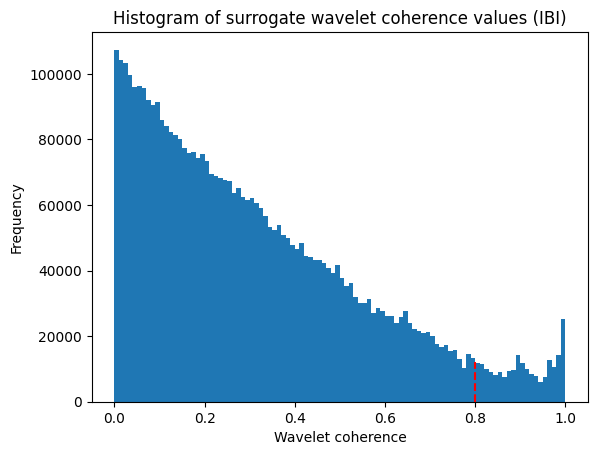

In [437]:
wct_surrogate_flattened = [wct.flatten() for wct in wct_surrogate]
wct_surrogate_concatenated = np.concatenate(wct_surrogate_flattened)
percentile_95_ibi = np.percentile(wct_surrogate_concatenated, 95)
print("95th percentile:", percentile_95_ibi)
plt.hist(wct_surrogate_concatenated, bins=100)
plt.vlines(percentile_95_ibi, 0, 12000, colors='r', linestyles='dashed')
plt.title('Histogram of surrogate wavelet coherence values (IBI)')
plt.xlabel('Wavelet coherence')
plt.ylabel('Frequency')
#plt.ylim(0, 12000)
plt.show()

In [438]:
with open('../data/surrogate_wavelet_coherence_ibi.npy', 'wb') as f:
    np.save(f, wct_surrogate_concatenated)
with open('../data/ibi_95_percentile.txt', 'w') as f:
    f.write(str(percentile_95_ibi))

### Calculating wavelet coherence between two signals

In [461]:
from matplotlib.ticker import FuncFormatter
def plot_wavelet_result(threshold, t, wct, awct, coi, freq, modality, ylim_low=None, ylim_high=None):
    # 周波数を周期に変換
    period = np.log2(1 / freq)  # 周波数を逆数にすることで周期を取得

    fig, ax = plt.subplots(figsize=(10, 5))

    # カラーマップのプロット
    contour = ax.contourf(
        t,
        period,  # 周期を y 軸に使用
        wct,
        levels=np.linspace(0, 1, 7)
    )

    # ベクトル成分計算
    u = np.cos(awct) * wct  # x成分
    v = np.sin(awct) * wct  # y成分

    # 時間-周期グリッドの作成
    X, Y = np.meshgrid(t, period)

    # 有意性マスクの作成
    significant_mask = wct > threshold

    # 矢印の間引き
    step = 5
    ax.quiver(
        X[significant_mask][::step],
        Y[significant_mask][::step],
        u[significant_mask][::step],
        v[significant_mask][::step],
        scale=50,
        color='black'
    )

    # COI をプロット（周期に変換したものを使用）
    coi_period = np.log2(coi)
    ax.plot(t, coi_period, 'k--', label='Cone of Influence')

    # カラーバーの追加
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label('Coherence Magnitude')

    # 軸ラベル、タイトル、範囲設定
    ax.set_title(f'Wavelet Coherence Magnitude with Phase Arrows ({modality})')
    ax.set_xlabel('Time')
    ax.set_ylabel('Period (seconds)')
    if ylim_low is not None and ylim_high is not None:
        ylim_low = np.log2(ylim_low)
        ylim_high = np.log2(ylim_high)
        ax.set_ylim(ylim_low, ylim_high)  # 周期の範囲に合わせる

    def log2_to_nonlog2(x, pos):
        return f'{2**x:.2f}'

    ax.yaxis.set_major_formatter(FuncFormatter(log2_to_nonlog2))
    
    # 凡例を追加
    ax.legend()

In [468]:
session = 'VM'
condition = 'research'
wct_ibi, awct_ibi, coi_ibi, freq_ibi, sig_ibi = wavelet.wct(ibi_standardized_p1[session][condition], ibi_standardized_p2[session][condition], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)

NOTE: WCT significance loaded from cache.



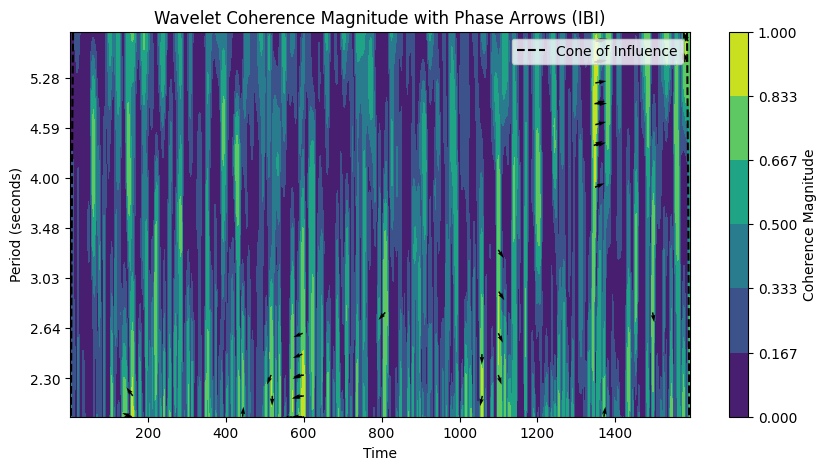

In [469]:
plot_wavelet_result(threshold=percentile_95_ibi, t=new_t[session][condition]/1000, wct=wct_ibi, awct=awct_ibi, coi=coi_ibi, freq=freq_ibi, modality='IBI', ylim_low=1/freq[0], ylim_high=6)
plt.savefig(f'../result/{session}_{condition}_ibi_HF.png')

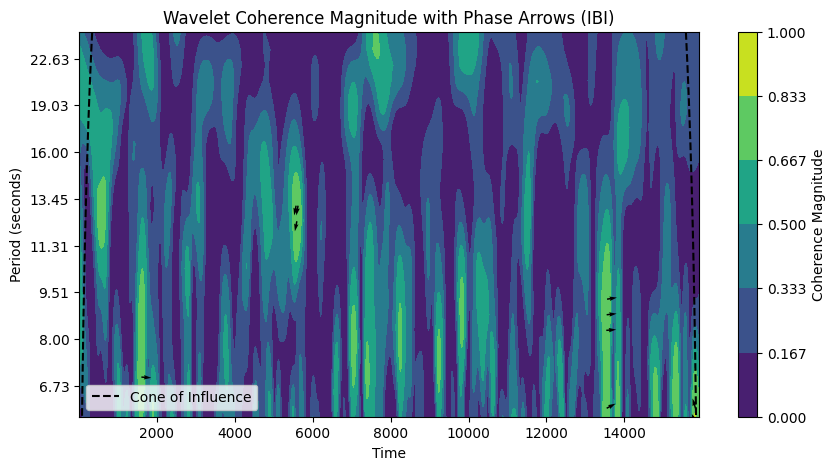

In [470]:
plot_wavelet_result(threshold=percentile_95_ibi, t=new_t[session][condition]/100, wct=wct_ibi, awct=awct_ibi, coi=coi_ibi, freq=freq_ibi, modality='IBI', ylim_low=6, ylim_high=25)
plt.savefig(f'../result/{session}_{condition}_ibi_LF.png')

### Summarizing results

In [471]:
wct_results_ibi = {}
for session in sessions:
    wct_results_ibi[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        wct_ibi, awct_ibi, coi_ibi, freq_ibi, sig_ibi = wavelet.wct(ibi_standardized_p1[session][condition], ibi_standardized_p2[session][condition], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
        wct_results_ibi[session][condition] = {}
        wct_results_ibi[session][condition]['wct'] = wct_ibi
        wct_results_ibi[session][condition]['awct'] = awct_ibi
        wct_results_ibi[session][condition]['coi'] = coi_ibi
        wct_results_ibi[session][condition]['freq'] = freq_ibi
        wct_results_ibi[session][condition]['sig'] = sig_ibi

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.

NOTE: WCT significance loaded from cache.



Text(0.5, 1.0, 'Wavelet Coherence Magnitude (IBI) in HF band')

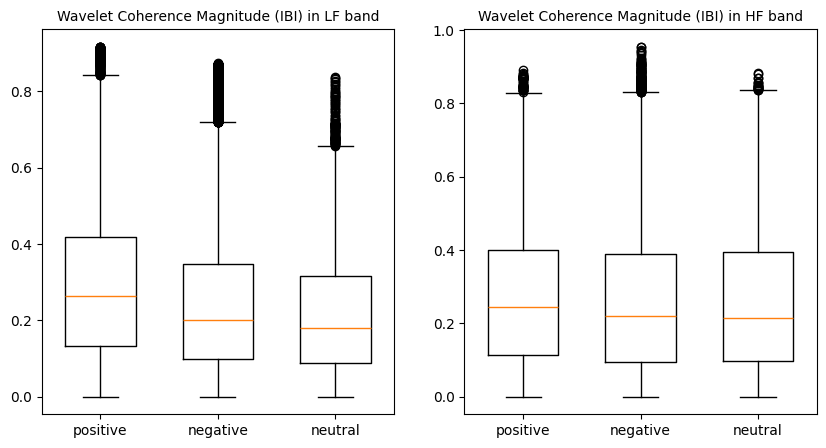

In [472]:
session = 'NN'
lf_wct_list = []
hf_wct_list = []
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
for condition in conditions_full:
    period = 1 / wct_results_ibi[session][condition]['freq']
    lf_freq = np.where((period >= 6) & (period <=25))
    hf_freq = np.where((period >= 2) & (period < 6))
    lf_wct = wct_results_ibi[session][condition]['wct'][lf_freq[0], :]
    hf_wct = wct_results_ibi[session][condition]['wct'][hf_freq[0], :]
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    axes[0].boxplot(lf_wct.flatten(), positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_wct.flatten(), positions=[conditions_full.index(condition)], widths=0.6)
for ax in axes:
    ax.set_xticklabels(conditions_full)
axes[0].set_title('Wavelet Coherence Magnitude (IBI) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence Magnitude (IBI) in HF band', fontsize=10)

In [473]:
kruskal(lf_wct_list[0].flatten(), lf_wct_list[1].flatten(), lf_wct_list[2].flatten())

KruskalResult(statistic=1371.301468922582, pvalue=1.6813940667123802e-298)

In [474]:
kruskal(hf_wct_list[0].flatten(), hf_wct_list[1].flatten(), hf_wct_list[2].flatten())

KruskalResult(statistic=66.37239079189021, pvalue=3.867394401289835e-15)

Text(0.5, 1.0, 'Wavelet Coherence Magnitude (IBI) in HF band')

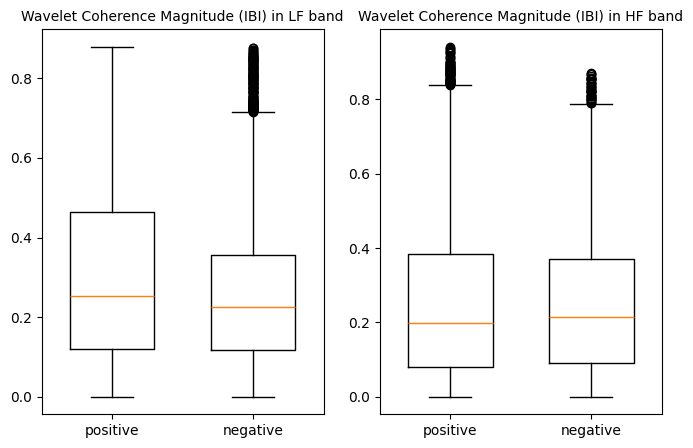

In [475]:
session = 'NY'
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
lf_wct_list = []
hf_wct_list = []
for condition in conditions_NY_ecg:
    period = 1 / wct_results_ibi[session][condition]['freq']
    lf_freq = np.where((period >= 6) & (period <=25))
    hf_freq = np.where((period >= 2) & (period < 6))
    lf_wct = wct_results_ibi[session][condition]['wct'][lf_freq[0], :]
    hf_wct = wct_results_ibi[session][condition]['wct'][hf_freq[0], :]
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    axes[0].boxplot(lf_wct.flatten(), positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_wct.flatten(), positions=[conditions_full.index(condition)], widths=0.6)
for ax in axes:
    ax.set_xticklabels(conditions_NY_ecg)
axes[0].set_title('Wavelet Coherence Magnitude (IBI) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence Magnitude (IBI) in HF band', fontsize=10)

In [476]:
mannwhitneyu(lf_wct[0].flatten(), lf_wct[1].flatten(), alternative='two-sided')

MannwhitneyuResult(statistic=189402.0, pvalue=0.730554040742916)

In [477]:
mannwhitneyu(hf_wct[0].flatten(), hf_wct[1].flatten(), alternative='two-sided')

MannwhitneyuResult(statistic=198091.0, pvalue=0.08018775214732916)

Text(0.5, 1.0, 'Wavelet Coherence Magnitude (IBI) in HF band')

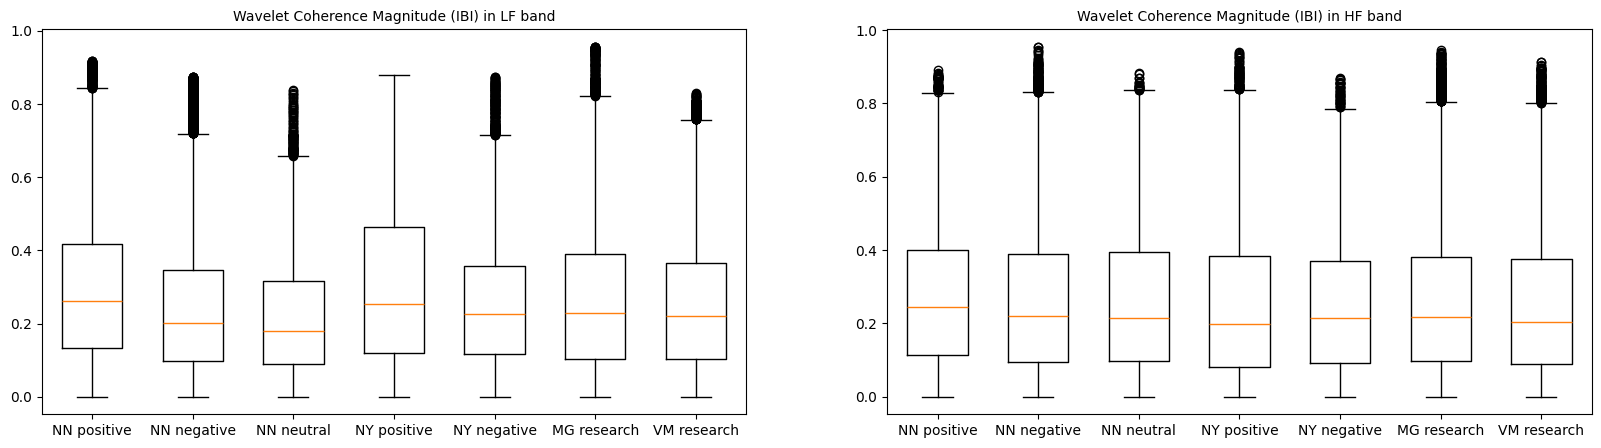

In [478]:
pos = 0
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
ticklabels = []
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        period = 1 / wct_results_ibi[session][condition]['freq']
        lf_freq = np.where((period >= 6) & (period <=25))
        hf_freq = np.where((period >= 2) & (period < 6))
        lf_wct = wct_results_ibi[session][condition]['wct'][lf_freq[0], :]
        hf_wct = wct_results_ibi[session][condition]['wct'][hf_freq[0], :]
        axes[0].boxplot(lf_wct.flatten(), positions = [pos], widths=0.6)
        axes[1].boxplot(hf_wct.flatten(), positions = [pos], widths=0.6)
        ticklabels.append(f'{session} {condition}')
        pos += 1
for ax in axes:
    ax.set_xticklabels(ticklabels)
axes[0].set_title('Wavelet Coherence Magnitude (IBI) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence Magnitude (IBI) in HF band', fontsize=10)

## **HRV analysis**

### Calculate second-by-second RMSSD

In [479]:
ibi_dfs_p1 = {}
ibi_dfs_p2 = {}

for session in sessions:
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    ibi_dfs_p1[session] = {}
    ibi_dfs_p2[session] = {}
    for condition in conditions:
        ibi_dfs_p1[session][condition] = mw_p1[session][condition][['timestamp', 'IBI']].set_index('timestamp')
        ibi_dfs_p2[session][condition] = mw_p2[session][condition][['timestamp', 'IBI']].set_index('timestamp')

In [480]:
window_len_sec = 30
window_step_size_sec = 1
hrv_p1 = {}
hrv_p2 = {}
rmssd_concat = {}

for session in sessions:
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    hrv_p1[session] = {}
    hrv_p2[session] = {}
    rmssd_concat[session] = {}
    for condition in conditions:
        hrv_p1[session][condition] = flirt.get_hrv_features(ibi_dfs_p1[session][condition]['IBI'], window_length=window_len_sec, window_step_size=window_step_size_sec, domains=['td'], clean_data=True)
        hrv_p2[session][condition] = flirt.get_hrv_features(ibi_dfs_p2[session][condition]['IBI'], window_length=window_len_sec, window_step_size=window_step_size_sec, domains=['td'], clean_data=True)
        rmssd_concat[session][condition] = pd.merge(hrv_p1[session][condition]['hrv_rmssd'], hrv_p2[session][condition]['hrv_rmssd'], on='datetime', how='inner', suffixes=('_p1', '_p2')) 

HRV features: 100%|██████████| 1564/1564 [00:00<00:00, 15359.54it/s]


In [481]:
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        time_offset_p1 = mw_p1[session][condition]['time'].iloc[0]
        start_time_p1 = mw_p1[session][condition]['timestamp'].iloc[0]
        df = rmssd_concat[session][condition].reset_index()
        df['time'] = (df['datetime'] - pd.to_datetime(start_time_p1)).dt.total_seconds() + time_offset_p1
        df = df.drop(columns=['datetime'])
        rmssd_concat[session][condition] = df

### Standardize HRV

In [482]:
standardized_rmssd = {}
for session in sessions:
    standardized_rmssd[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        df = rmssd_concat[session][condition].copy()
        df['hrv_rmssd_p1'] = (df['hrv_rmssd_p1'] - np.mean(df['hrv_rmssd_p1'])) / np.std(df['hrv_rmssd_p1'])
        df['hrv_rmssd_p2'] = (df['hrv_rmssd_p2'] - np.mean(df['hrv_rmssd_p2'])) / np.std(df['hrv_rmssd_p2'])
        standardized_rmssd[session][condition] = df

### Surrogate analysis

In [483]:
standardized_rmssd_all = {}

for session in standardized_rmssd.keys():
    person = session
    standardized_rmssd_all[session] = {}
    for condition in standardized_rmssd[session].keys():
        standardized_rmssd_all[session][condition] = {}
        standardized_rmssd_all[session][condition][person] = standardized_rmssd[session][condition]['hrv_rmssd_p1']
for session in standardized_rmssd.keys():
    person = 'YW'
    for condition in standardized_rmssd[session].keys():
        standardized_rmssd_all[session][condition][person] = standardized_rmssd[session][condition]['hrv_rmssd_p2']

In [484]:
wct_surrogate = []

for pair_i in range(len(surrogate_pairs)):
    print(f'Processing pair {pair_i+1}/{len(surrogate_pairs)}')
    session1 = surrogate_pairs.loc[pair_i, 'session1']
    condition1 = surrogate_pairs.loc[pair_i, 'condition1']
    person1 = surrogate_pairs.loc[pair_i, 'person1']
    session2 = surrogate_pairs.loc[pair_i, 'session2']
    condition2 = surrogate_pairs.loc[pair_i, 'condition2']
    person2 = surrogate_pairs.loc[pair_i, 'person2']
    print(f'    {session1} {condition1} {person1} vs {session2} {condition2} {person2}')
    
    max_idx = min(len(standardized_rmssd_all[session1][condition1][person1]), len(standardized_rmssd_all[session2][condition2][person2]))
    try:
        wct, awct, coi, freq, sig = wavelet.wct(standardized_rmssd_all[session1][condition1][person1][:max_idx], standardized_rmssd_all[session2][condition2][person2][:max_idx], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
        wct_surrogate.append(wct)
    except:
        print(f'    Error in {session1} {condition1} {person1} vs {session2} {condition2} {person2}')
        pass

Processing pair 1/59
    NY positive NY vs VM research VM
Processing pair 2/59
    NN negative YW vs NN neutral NN
Processing pair 3/59
    NN neutral NN vs NY negative YW
Processing pair 4/59
    NN neutral NN vs NY positive NY
Processing pair 5/59
    NN neutral NN vs VM research VM
Processing pair 6/59
    NN negative YW vs MG research MG
Processing pair 7/59
    NN neutral YW vs MG research MG
Processing pair 8/59
    NN positive NN vs NN neutral YW
Processing pair 9/59
    NY negative NY vs VM research VM
Processing pair 10/59
    NN positive YW vs NY positive NY
Processing pair 11/59
    NN positive NN vs NY negative NY
Processing pair 12/59
    NN negative NN vs NN neutral YW
Processing pair 13/59
    NN negative NN vs MG research YW
Processing pair 14/59
    MG research MG vs VM research VM
Processing pair 15/59
    NN positive NN vs MG research YW
Processing pair 16/59
    NN negative NN vs NY negative NY
Processing pair 17/59
    NN positive YW vs VM research VM
Processing pa

95th percentile: 0.7803975139320777


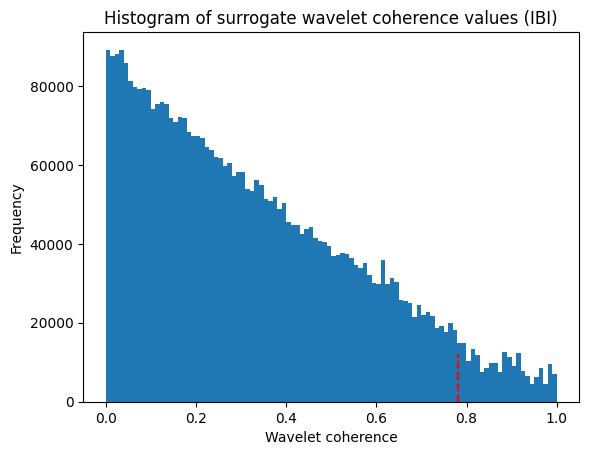

In [485]:
wct_surrogate_flattened = [wct.flatten() for wct in wct_surrogate]
wct_surrogate_concatenated = np.concatenate(wct_surrogate_flattened)
percentile_95_hrv = np.percentile(wct_surrogate_concatenated, 95)
print("95th percentile:", percentile_95_hrv)
plt.hist(wct_surrogate_concatenated, bins=100)
plt.vlines(percentile_95_hrv, 0, 12000, colors='r', linestyles='dashed')
plt.title('Histogram of surrogate wavelet coherence values (IBI)')
plt.xlabel('Wavelet coherence')
plt.ylabel('Frequency')
# plt.ylim(0, 12000)
plt.show()

In [486]:
with open('../data/surrogate_wavelet_coherence_hrv.npy', 'wb') as f:
    np.save(f, wct_surrogate_concatenated)
with open('../data/hrv_95_percentile.txt', 'w') as f:
    f.write(str(percentile_95_hrv))

### Cross wavelet transform

In [512]:
session = 'NY'
condition = 'negative'
wct_rmssd, awct_rmssd, coi_rmssd, freq_rmssd, sig_rmssd = wavelet.wct(standardized_rmssd[session][condition]['hrv_rmssd_p1'], standardized_rmssd[session][condition]['hrv_rmssd_p2'], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)

In [513]:
t = standardized_rmssd[session][condition]['time'].values

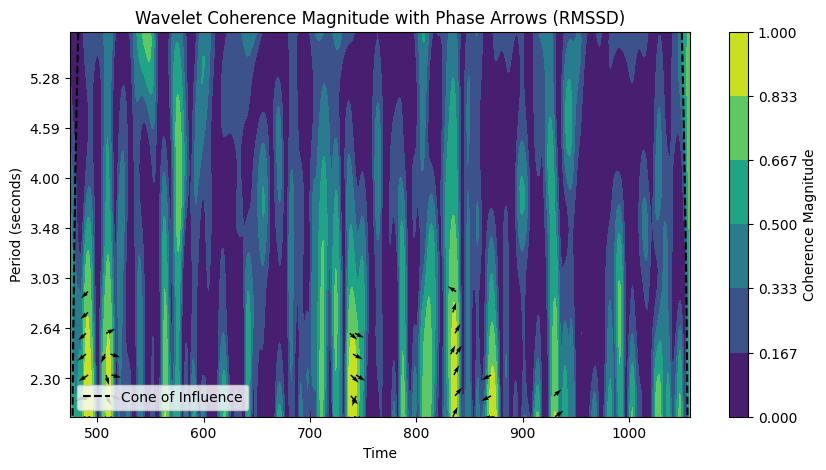

In [514]:
plot_wavelet_result(threshold=percentile_95_hrv, t=t, wct=wct_rmssd, awct=awct_rmssd, coi=coi_rmssd, freq=freq_rmssd, modality='RMSSD', ylim_low=1/freq[0], ylim_high=6)
plt.savefig(f'../result/{session}_{condition}_rmssd_HF.png')

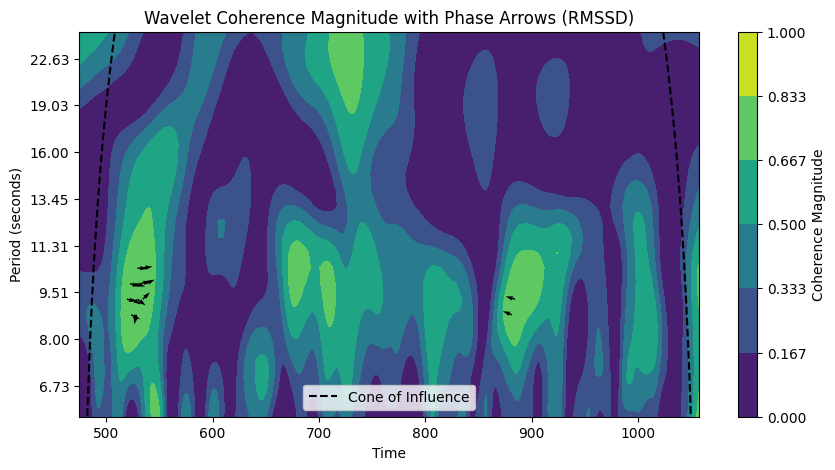

In [515]:
plot_wavelet_result(threshold=percentile_95_hrv, t=t, wct=wct_rmssd, awct=awct_rmssd, coi=coi_rmssd, freq=freq_rmssd, modality='RMSSD', ylim_low=6, ylim_high=25)
plt.savefig(f'../result/{session}_{condition}_rmssd_LF.png')

### Summarizing results

In [516]:
wct_results_hrv = {}
for session in sessions:
    wct_results_hrv[session] = {}
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        wct_hrv, awct_hrv, coi_hrv, freq_hrv, sig_hrv = wavelet.wct(standardized_rmssd[session][condition]['hrv_rmssd_p1'], standardized_rmssd[session][condition]['hrv_rmssd_p2'], dt, dj=dj, s0=s0, J=-1, sig=False, wavelet=mother, normalize=True)
        wct_results_hrv[session][condition] = {}
        wct_results_hrv[session][condition]['wct'] = wct_hrv
        wct_results_hrv[session][condition]['awct'] = awct_hrv
        wct_results_hrv[session][condition]['coi'] = coi_hrv
        wct_results_hrv[session][condition]['freq'] = freq_hrv
        wct_results_hrv[session][condition]['sig'] = sig_hrv

Text(0.5, 1.0, 'Wavelet Coherence Magnitude (RMSSD) in HF band')

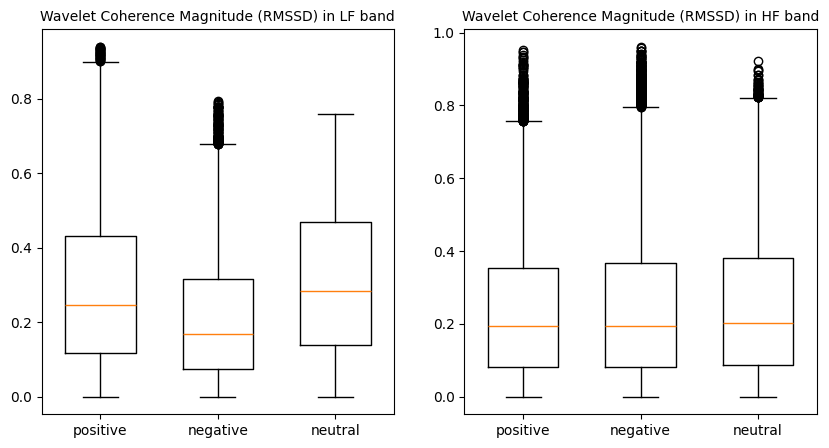

In [517]:
session = 'NN'
lf_wct_list = []
hf_wct_list = []
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
for condition in conditions_full:
    period = 1 / wct_results_hrv[session][condition]['freq']
    lf_freq = np.where((period >= 6) & (period <=25))
    hf_freq = np.where((period >= 2) & (period < 6))
    lf_wct = wct_results_hrv[session][condition]['wct'][lf_freq[0], :]
    hf_wct = wct_results_hrv[session][condition]['wct'][hf_freq[0], :]
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    axes[0].boxplot(lf_wct.flatten(), positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_wct.flatten(), positions=[conditions_full.index(condition)], widths=0.6)
for ax in axes:
    ax.set_xticklabels(conditions_full)
axes[0].set_title('Wavelet Coherence Magnitude (RMSSD) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence Magnitude (RMSSD) in HF band', fontsize=10)

In [518]:
kruskal(lf_wct_list[0].flatten(), lf_wct_list[1].flatten(), lf_wct_list[2].flatten())

KruskalResult(statistic=2717.579631122615, pvalue=0.0)

In [519]:
mannwhitneyu(lf_wct[0].flatten(), lf_wct[1].flatten(), alternative='two-sided')

MannwhitneyuResult(statistic=187904.0, pvalue=0.8462277497517694)

In [520]:
mannwhitneyu(lf_wct[1].flatten(), lf_wct[2].flatten(), alternative='two-sided')

MannwhitneyuResult(statistic=188916.0, pvalue=0.9748978482013715)

In [521]:
mannwhitneyu(lf_wct[0].flatten(), lf_wct[2].flatten(), alternative='two-sided')

MannwhitneyuResult(statistic=187546.0, pvalue=0.8014990656666198)

In [522]:
kruskal(hf_wct_list[0].flatten(), hf_wct_list[1].flatten(), hf_wct_list[2].flatten())

KruskalResult(statistic=18.550301066657994, pvalue=9.372453718833941e-05)

Text(0.5, 1.0, 'Wavelet Coherence Magnitude (RMSSD) in HF band')

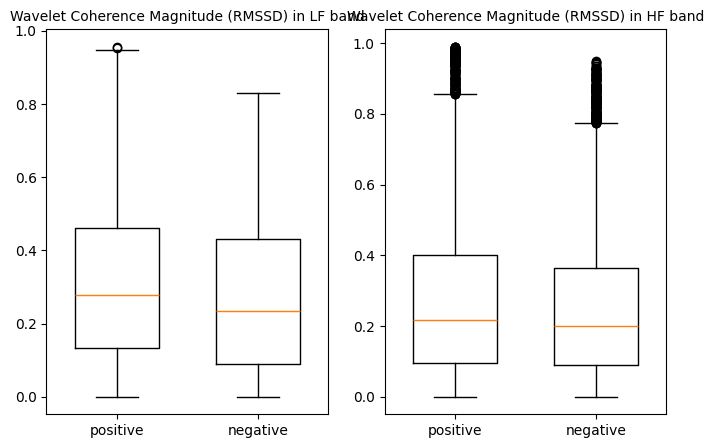

In [523]:
session = 'NY'
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
lf_wct_list = []
hf_wct_list = []
for condition in conditions_NY_ecg:
    period = 1 / wct_results_hrv[session][condition]['freq']
    lf_freq = np.where((period >= 6) & (period <=25))
    hf_freq = np.where((period >= 2) & (period < 6))
    lf_wct = wct_results_hrv[session][condition]['wct'][lf_freq[0], :]
    hf_wct = wct_results_hrv[session][condition]['wct'][hf_freq[0], :]
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    axes[0].boxplot(lf_wct.flatten(), positions=[conditions_full.index(condition)], widths=0.6)
    axes[1].boxplot(hf_wct.flatten(), positions=[conditions_full.index(condition)], widths=0.6)
for ax in axes:
    ax.set_xticklabels(conditions_NY_ecg)
axes[0].set_title('Wavelet Coherence Magnitude (RMSSD) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence Magnitude (RMSSD) in HF band', fontsize=10)

In [524]:
mannwhitneyu(lf_wct[0].flatten(), lf_wct[1].flatten(), alternative='two-sided')

MannwhitneyuResult(statistic=152779.0, pvalue=0.0020758556476870513)

In [525]:
mannwhitneyu(hf_wct[0].flatten(), hf_wct[1].flatten(), alternative='two-sided')

MannwhitneyuResult(statistic=179328.0, pvalue=0.12685765762818918)

Text(0.5, 1.0, 'Wavelet Coherence Magnitude (RMSSD) in HF band')

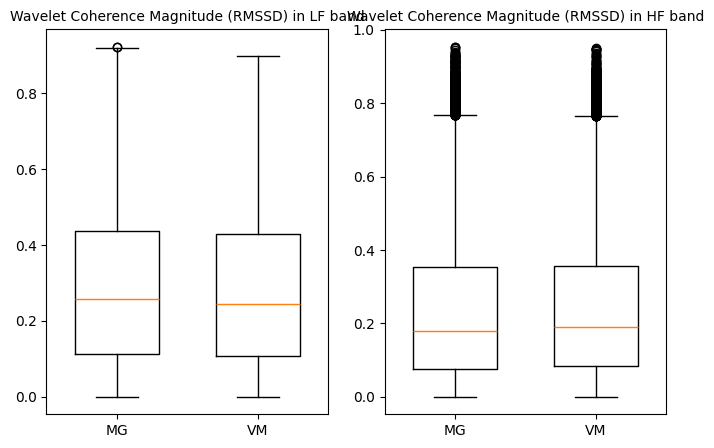

In [526]:
condition = 'research'
sessions_research = ['MG', 'VM']
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 5))
lf_wct_list = []
hf_wct_list = []
for session in sessions_research:
    period = 1 / wct_results_hrv[session][condition]['freq']
    lf_freq = np.where((period >= 6) & (period <=25))
    hf_freq = np.where((period >= 2) & (period < 6))
    lf_wct = wct_results_hrv[session][condition]['wct'][lf_freq[0], :]
    hf_wct = wct_results_hrv[session][condition]['wct'][hf_freq[0], :]
    lf_wct_list.append(lf_wct)
    hf_wct_list.append(hf_wct)
    axes[0].boxplot(lf_wct.flatten(), positions=[sessions_research.index(session)], widths=0.6)
    axes[1].boxplot(hf_wct.flatten(), positions=[sessions_research.index(session)], widths=0.6)
for ax in axes:
    ax.set_xticklabels(sessions_research)
axes[0].set_title('Wavelet Coherence Magnitude (RMSSD) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence Magnitude (RMSSD) in HF band', fontsize=10)

Text(0.5, 1.0, 'Wavelet Coherence Magnitude (RMSSD) in HF band')

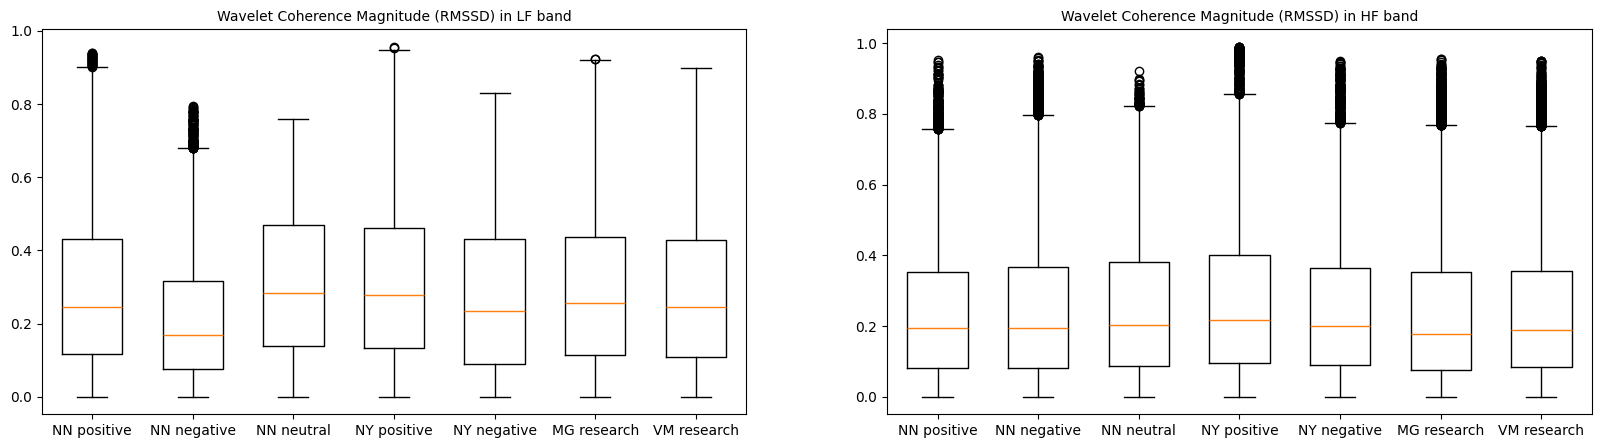

In [527]:
pos = 0
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
ticklabels = []
for session in sessions:
    if session == 'NN':
        conditions = conditions_full
    elif session == 'NY':
        conditions = conditions_NY_ecg
    else:
        conditions = conditions_VM_MG
    for condition in conditions:
        period = 1 / wct_results_hrv[session][condition]['freq']
        lf_freq = np.where((period >= 6) & (period <=25))
        hf_freq = np.where((period >= 2) & (period < 6))
        lf_wct = wct_results_hrv[session][condition]['wct'][lf_freq[0], :]
        hf_wct = wct_results_hrv[session][condition]['wct'][hf_freq[0], :]
        axes[0].boxplot(lf_wct.flatten(), positions = [pos], widths=0.6)
        axes[1].boxplot(hf_wct.flatten(), positions = [pos], widths=0.6)
        ticklabels.append(f'{session} {condition}')
        pos += 1
for ax in axes:
    ax.set_xticklabels(ticklabels)
axes[0].set_title('Wavelet Coherence Magnitude (RMSSD) in LF band', fontsize=10)
axes[1].set_title('Wavelet Coherence Magnitude (RMSSD) in HF band', fontsize=10)

## **Audio analysis**

In [308]:
if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is not available. Using CPU.


In [309]:
classifier = pipeline("audio-classification", model="superb/wav2vec2-base-superb-er")

/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [340]:
# Load the audio file
session = 'VM'
condition = 'research_ecg'
audio_file_path = f'../data/audio_clipped/{session}_{condition}.wav'
y, sr = librosa.load(audio_file_path, sr=None, mono=False)
print(f"Original sampling rate: {sr} Hz")

# Check the number of channels
if len(y.shape) > 1:
    print(f"Original audio has {y.shape[0]} channels.")
    # Convert to mono (average the channels)
    y_mono = librosa.to_mono(y)
else:
    print("Original audio is already mono.")
    y_mono = y

# Downsample the audio
new_sr = 15000
y_downsampled = librosa.resample(y_mono, orig_sr=sr, target_sr=new_sr)

# Save the downsampled audio to a new file
downsampled_audio_file_path = f'../data/audio_clipped/{session}_{condition}_downsampled.wav'
sf.write(downsampled_audio_file_path, y_downsampled, new_sr)
print(f"Downsampled audio saved at {downsampled_audio_file_path} with sampling rate {new_sr} Hz and mono channel.")

Original sampling rate: 44100 Hz
Original audio has 2 channels.
Downsampled audio saved at ../data/audio_clipped/VM_research_ecg_downsampled.wav with sampling rate 15000 Hz and mono channel.


In [341]:
def split_audio(waveform, sample_rate, window_size=5):
    """Split the audio waveform into chunks of a specified window size."""
    num_samples = int(window_size * sample_rate)
    return torch.split(waveform, num_samples)

waveform, sample_rate = torchaudio.load(downsampled_audio_file_path)
waveform = waveform.squeeze(0)
input_values = waveform.numpy()

chunks = split_audio(waveform, sample_rate=16000, window_size=5)
results_all = []
for chunk in chunks:
    input_values = chunk.numpy()
    results = classifier({"array": input_values, "sampling_rate": 16000}, top_k=5)
    results_all.append(results)

labels = [result[0]['label'] for result in results_all]

with open(f'../cache/{session}_{condition}_audio_labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

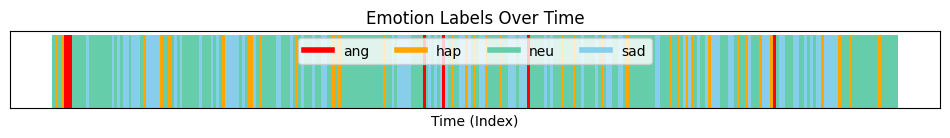

In [342]:
label_colors = {'ang': 'red', 'hap': 'orange', 'neu': 'mediumaquamarine', 'sad': 'skyblue'}

x = np.arange(len(labels))

colors = [label_colors[label] for label in labels]

plt.figure(figsize=(12, 1))
plt.bar(x, [1] * len(labels), color=colors, width=1.0, align='edge')  # 幅1.0で色分け
plt.xticks(ticks=[], labels=[])  # 軸ラベルを非表示
plt.yticks([])  # Y軸の目盛りを非表示
plt.xlabel('Time (Index)')
plt.title('Emotion Labels Over Time')

legend_labels = list(label_colors.keys())
legend_colors = [plt.Line2D([0], [0], color=label_colors[label], lw=4) for label in legend_labels]
plt.legend(legend_colors, legend_labels, loc='upper center', ncol=len(label_colors))

plt.show()

## **Combining physiology and audio data**

In [531]:
from matplotlib.gridspec import GridSpec
def plot_wavelet_audio_result(labels, threshold, t, wct, awct, coi, freq, modality, ylim_low=None, ylim_high=None):
    fig = plt.figure(figsize=(10, 5))

    axes=[]
    gs = GridSpec(nrows=2, ncols=1, height_ratios=[3, 1], figure=fig)
    axes.append(fig.add_subplot(gs[0]))
    axes.append(fig.add_subplot(gs[1], sharex=axes[0]))

    # 周波数を周期に変換
    period = np.log2(1 / freq)  # 周波数を逆数にすることで周期を取得

    # カラーマップのプロット
    contour = axes[0].contourf(
        t,
        period,  # 周期を y 軸に使用
        wct,
        levels=np.linspace(0, 1, 7)
    )

    # ベクトル成分計算
    u = np.cos(awct) * wct  # x成分
    v = np.sin(awct) * wct  # y成分

    # 時間-周期グリッドの作成
    X, Y = np.meshgrid(t, period)

    # 有意性マスクの作成
    significant_mask = wct > threshold

    # 矢印の間引き
    step = 5
    axes[0].quiver(
        X[significant_mask][::step],
        Y[significant_mask][::step],
        u[significant_mask][::step],
        v[significant_mask][::step],
        scale=50,
        color='black'
    )

    # COI をプロット（周期に変換したものを使用）
    coi_period = np.log2(coi)
    axes[0].plot(t, coi_period, 'k--', label='Cone of Influence')

    # 軸ラベル、タイトル、範囲設定
    axes[0].set_title(f'Wavelet Coherence Magnitude with Phase Arrows ({modality})')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Period (seconds)')
    if ylim_low is not None and ylim_high is not None:
        ylim_low = np.log2(ylim_low)
        ylim_high = np.log2(ylim_high)
        axes[0].set_ylim(ylim_low, ylim_high)  # 周期の範囲に合わせる

    def log2_to_nonlog2(x, pos):
        return f'{2**x:.2f}'

    axes[0].yaxis.set_major_formatter(FuncFormatter(log2_to_nonlog2))
    
    # 凡例を追加
    axes[0].legend()
    
    time_audio = np.arange(0, len(labels) * 5, 5)

    label_colors = {'ang': 'red', 'hap': 'orange', 'neu': 'mediumaquamarine', 'sad': 'skyblue'}

    colors = [label_colors[label] for label in labels]

    axes[1].bar(time_audio, [5] * len(labels), color=colors, width=5.0, align='edge')  # 幅1.0で色分け
    axes[1].set_xticks(ticks=[], labels=[])  # 軸ラベルを非表示
    axes[1].set_yticks([])  # Y軸の目盛りを非表示
    axes[1].set_xlabel('Time')

    legend_labels = list(label_colors.keys())
    legend_colors = [plt.Line2D([0], [0], color=label_colors[label], lw=4) for label in legend_labels]
    axes[1].legend(legend_colors, legend_labels, loc='upper center', ncol=len(label_colors))

    axes[0].set_xlim(0, len(t)-1)
    axes[1].set_xlim(0, len(t)-1)

    plt.show()

In [529]:
session = 'NN'
condition = 'positive'
pickle_file_path = f'../cache/{session}_{condition}_audio_labels.pkl'

with open(pickle_file_path, 'rb') as f:
    labels = pickle.load(f)

/Users/yuna.w/Research/CBSL/linkage_analysis/.venv/lib/python3.12/site-packages/pycwt/wavelet.py:633: RuntimeWarning: invalid value encountered in arctanh
  aa = numpy.round(numpy.arctanh(numpy.array([al1, al2]) * 4))


NOTE: WCT significance loaded from cache.



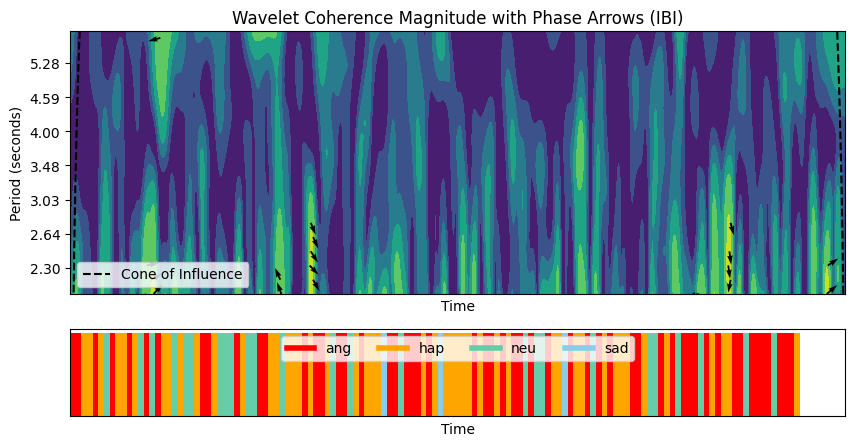

In [532]:
wct_ibi, awct_ibi, coi_ibi, freq_ibi, sig_ibi = wavelet.wct(ibi_standardized_p1[session][condition], ibi_standardized_p2[session][condition], dt, dj=dj, s0=s0, J=-1, sig=True, wavelet=mother, normalize=True)
plot_wavelet_audio_result(labels, percentile_95_ibi, new_t[session][condition] / 1000, wct_ibi, awct_ibi, coi_ibi, freq_ibi, 'IBI', ylim_low=1/freq[0], ylim_high=6)

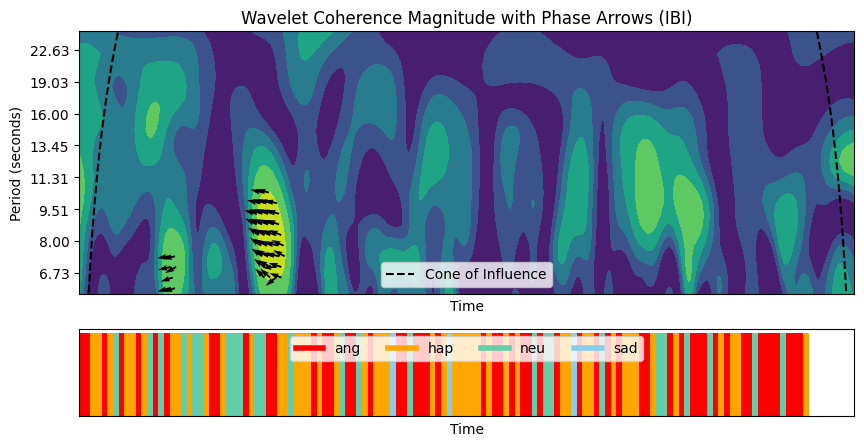

In [533]:
plot_wavelet_audio_result(labels, percentile_95_ibi, new_t[session][condition] / 1000, wct_ibi, awct_ibi, coi_ibi, freq_ibi, 'IBI', ylim_low=6, ylim_high=25)

In [392]:
len(labels * 5)

645

In [391]:
len(new_t[session][condition])

686